In [100]:
import importlib
import os
import sys

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

import financial_data_structs as fds
# adding parent dir to path
sys.path.append(os.path.dirname(os.path.abspath('')))
import adv_fin_ml_func as fml

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 14.0)
importlib.reload(sys.modules['adv_fin_ml_func'])
importlib.reload(sys.modules['financial_data_structs'])

<module 'financial_data_structs' from '/mnt/c/Users/mlevy/Workspace/Advances-in-Financial-Machine-Learning/F-ML/data_analysis/financial_data_structs.py'>

In [2]:
plt.rcParams['figure.figsize'] = (20.0, 14.0)

In [3]:
out_fp = '../data/clean/IVE_tick.parq'
df = fds.parquet_to_df(out_fp)
df.head()

,price,bid,ask,volume,dollar_volume
timestamp,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,5075.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,5075.00
2009-09-28 09:31:50,50.75,50.73,50.76,300,15225.00


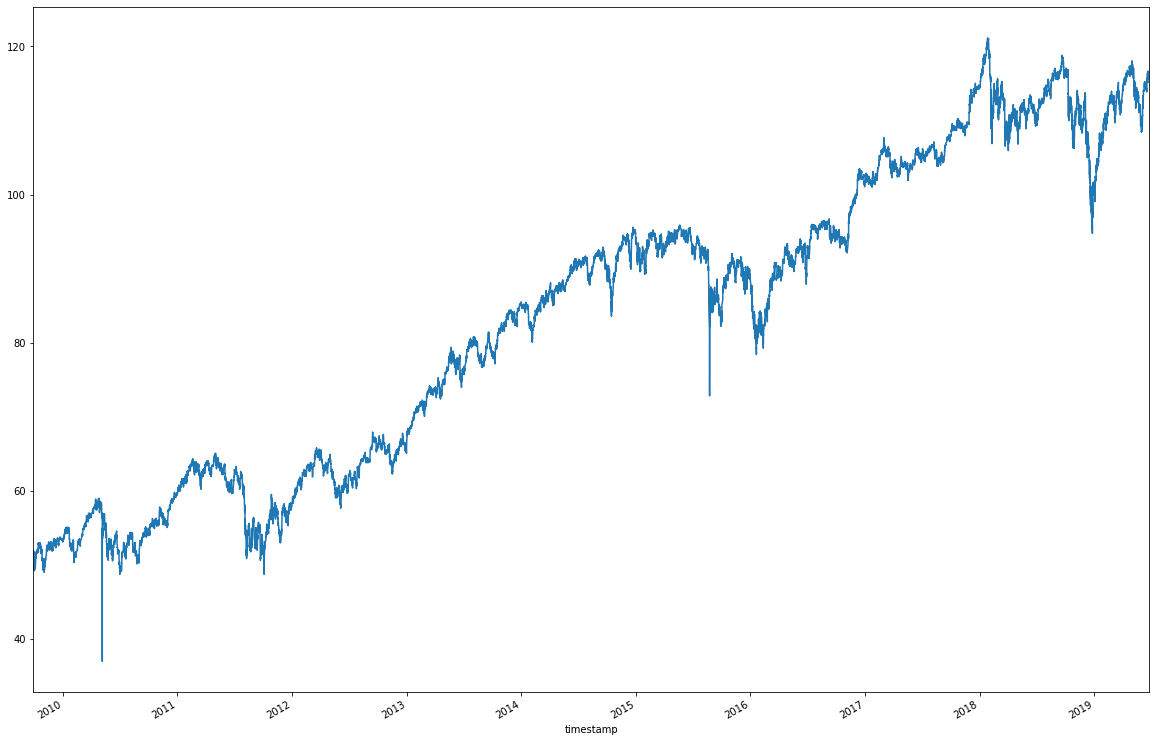

In [4]:
df_dol = fds.get_dollar_bars(df, 1_000_000)
df_dol.price.plot()

### 4.1
Calculate first barrier touches on dollar bars then calculate the number of overlapping outcomes at each point in time. Plot the time series of the number of concurrent labels on the primary axis, and the time series of exponentially weighted moving standard deviation of returns on the secondary axis. Last, produce a scatterplot of the number of concurrent labels (x-axis) and the exponentially weighted moving standard deviation of returns (y-axis).

In [5]:
close = df_dol.price.copy()

# Remove duplicate indexes
close = close[~close.index.duplicated()]

# getting standard deviation of daily returns
dailyVol = fml.getDailyVol(close)

# CUSUM Filter
tEvents = fml.getTEvents(close, h=dailyVol.mean())

In [6]:
# Adding Vertical bars
# This is the expiration limit in our triple barrier method
t1 = fml.addVerticalBarrier(tEvents, close, numDays=1)

# Applying triple-barrier method
minRet = 0.005
numThreads = 1
ptSl = [1, 1]
events = fml.getEvents(close, tEvents, ptSl, dailyVol, minRet, numThreads, t1=t1).dropna()

In [7]:
# Overlapping outcomes
numCoEvents = fml.mpPandasObj(fml.mpNumCoEvents, ('molecule',events.index), numThreads, closeIdx=close.index, t1=events.t1)

numCoEvents = numCoEvents.reindex(close.index).fillna(0)

In [8]:
coEvents_std = pd.DataFrame().assign(numCoEvents=numCoEvents, ma_std=fds.calc_returns(close).ewm(50).std())

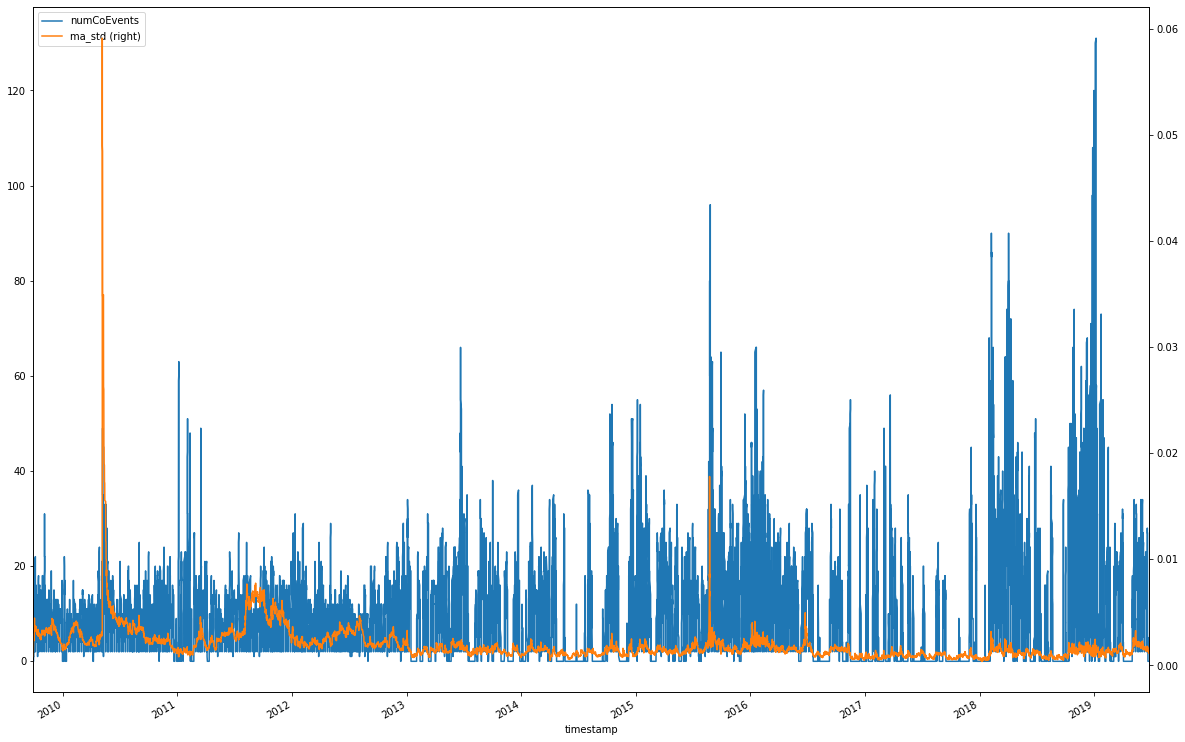

In [9]:
coEvents_std.numCoEvents.plot(legend=True)
coEvents_std.ma_std.plot(secondary_y=True, legend=True)

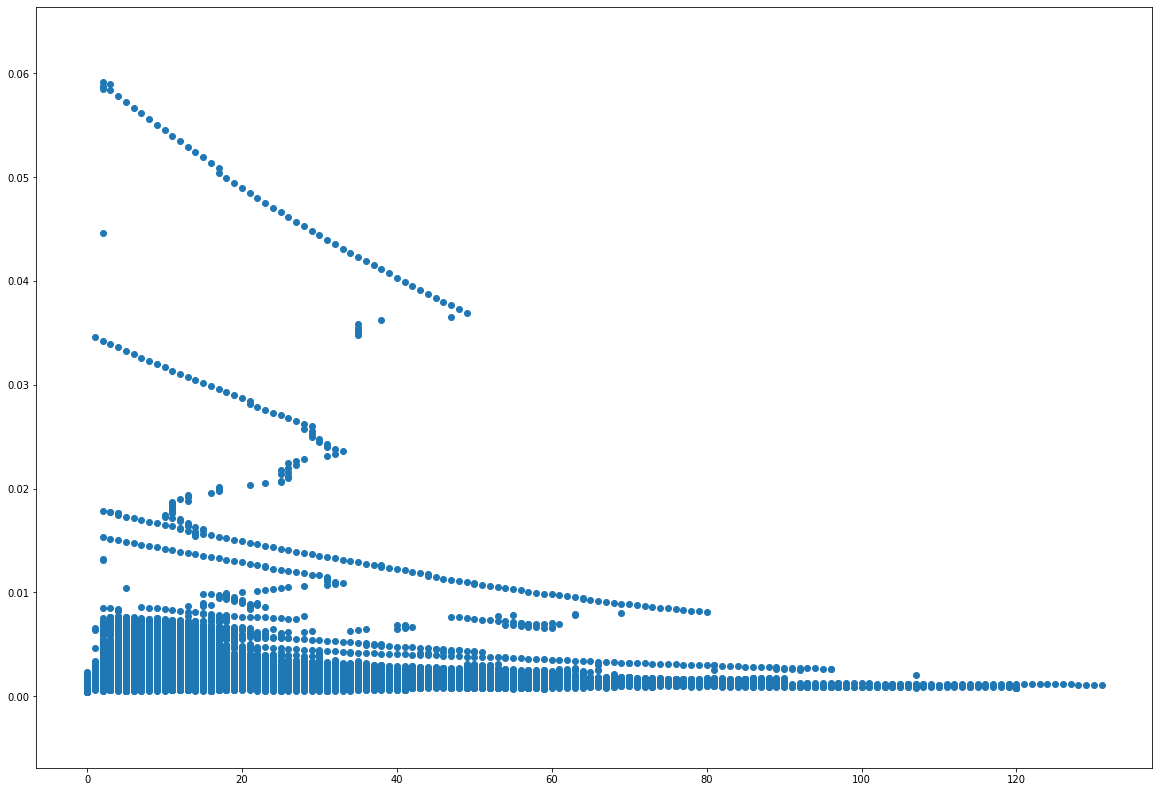

In [10]:
plt.scatter(coEvents_std.numCoEvents, coEvents_std.ma_std)

### 4.2
Compute the average uniqueness of each label. Determine the first-order serial correlation, AR(1), of this time series.

In [11]:
out = pd.DataFrame()
out['tW'] = fml.mpPandasObj(fml.mpSampleTW,('molecule', events.index),
                        numThreads, t1=events.t1, numCoEvents=numCoEvents)

(array([5.214e+03, 9.210e+03, 8.428e+03, 5.667e+03, 3.499e+03, 2.014e+03,
        1.182e+03, 7.190e+02, 4.630e+02, 2.670e+02, 1.890e+02, 1.090e+02,
        7.600e+01, 5.800e+01, 4.700e+01, 2.900e+01, 2.400e+01, 1.900e+01,
        9.000e+00, 5.000e+00, 1.600e+01, 4.000e+00, 9.000e+00, 4.000e+00,
        3.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        3.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([0.00766295, 0.02750969, 0.04735643, 0.06720317, 0.08704991,
        0.10689665, 0.12674339, 0.14659014, 0.16643688, 0.18628362,
        0.20613036, 0.2259771 , 0.24582384, 0.26567058, 0.28551732,
        0.30536406, 0.3252108 , 0.34505755, 0.36490429, 0.38475103,
        0.40459777, 0.42444451, 0.44429125, 0.46413799, 0.48398473,
        0.50383147, 0.52367821, 0.54

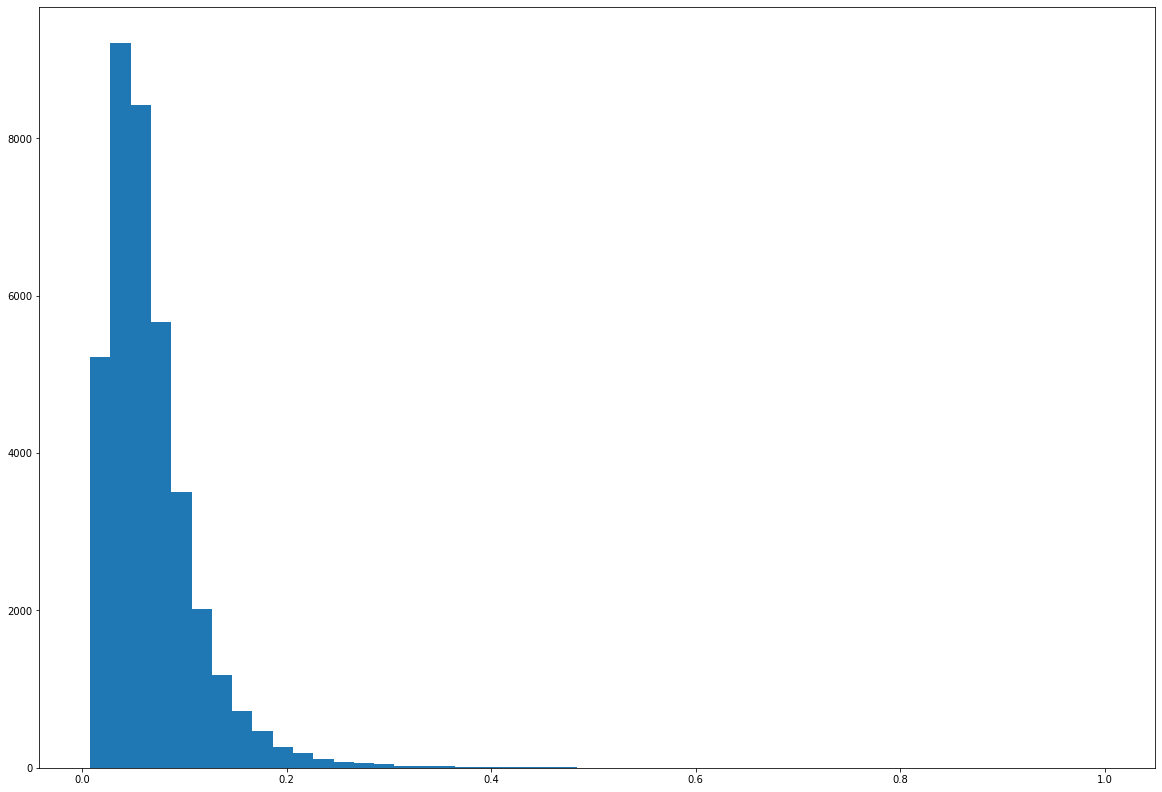

In [12]:
plt.hist(out.tW, bins=50)

In [13]:
out['tW'].autocorr()

0.8639457602463516

### 4.3
Fit a random forest to a financial dataset where $I^{-1}\sum\limits_{i=1}^{I}\overline{u}_i << 1$ (i.e. very non-unique labels)  
Determine the mean out-of-bag accuracy with and without k-fold cross-validation

In [133]:
# Predict close price based  off a lagged price
df = pd.DataFrame().assign(close=close, close_lag=close.shift(1)).dropna()
X = df.close_lag.values.reshape(-1, 1)
y = df.close.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)
rf = RandomForestRegressor(n_estimators=100, max_depth=1, random_state=123, oob_score=True)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=True, random_state=123, verbose=0,
                      warm_start=False)

In [134]:
rf.oob_score_

0.7925413223658536

In [135]:
cross_val_score(rf, X, y, cv=5, scoring='r2').mean()

-9.886560396617195

Out of bag accuracy so much higher than cross-validation since the in-bag observations are redundant to each other and very similar to out of bag observations. With random forest, all the trees will be very similar copies of a single overfit decision tree and hence the out of bag accuracy will be grossly inflated. Cross-validation accuracy will be less biased since it is less redundant.

### 4.4
Modify the linear time decay function below to exponential decay

In [136]:
# 4.4
def getTimeDecay(tW, clfLastW=1.):
    # apply piecewise-linear decay to observed uniqueness (tW)
    # newest observation gets weight=1, oldest observation gets weight=clfLastW
    clfW = tW.sort_index().cumsum()
    if clfLastW >= 0:
        slope = (1.-clfLastW)/clfW.iloc[-1]
    else:
        slope = 1./((clfLastW+1)*clfW.iloc[-1])
    const = 1.-slope*clfW.iloc[-1]
    clfW = const+slope*clfW
    clfW[clfW < 0] = 0
    print(const, slope)
    return clfW

1.0 0.0
0.75 9.962511770944863e-05
0.5 0.00019925023541889726
0.0 0.0003985004708377945
-0.3333333333333335 0.0005313339611170595
-1.0 0.000797000941675589


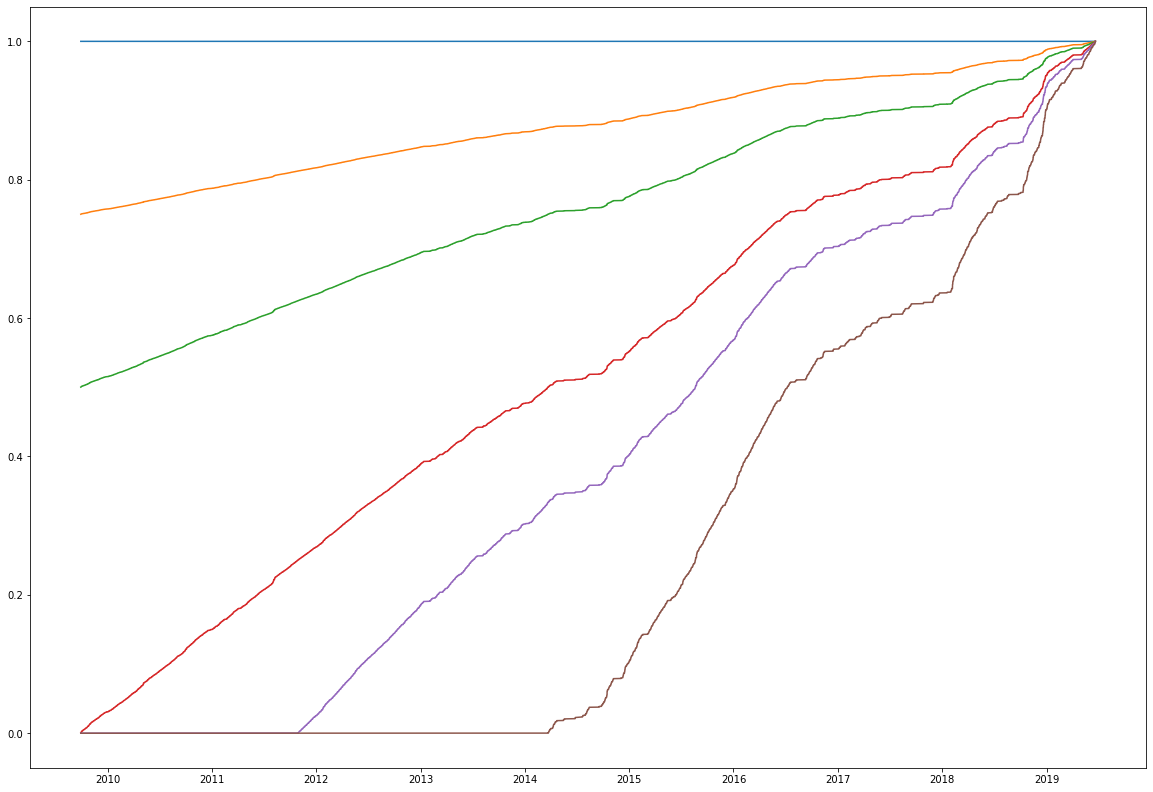

In [142]:
for i in [1, .75, .5, 0, -.25, -.5]:
    clfW = getTimeDecay(out['tW'], i)
    plt.plot(clfW)

In [139]:
def getExpTimeDecay(tW, clfLastW=1., exp=1.):
    # apply exponential decay to observed uniqueness (tW)
    # newest observation gets weight=1, oldest observation gets weight=clfLastW
    clfW = tW.sort_index().cumsum()
    if clfLastW >= 0:
        slope = ((1.-clfLastW)/clfW.iloc[-1])**exp
    else:
        slope = (1./((clfLastW+1)*clfW.iloc[-1]))**exp
    const = 1.-slope*clfW.iloc[-1]
    clfW = const+slope*clfW
    clfW[clfW < 0] = 0
    print(const, slope)
    return clfW

1.0 0.0
-1.5023485195141744 0.0009971870632266566
-3.2084317995498184 0.0016770620536093496
-6.077710428162362 0.0028204709380762697
-7.782068954353997 0.0034996586132400457
-10.903242654491127 0.0047434478023112335


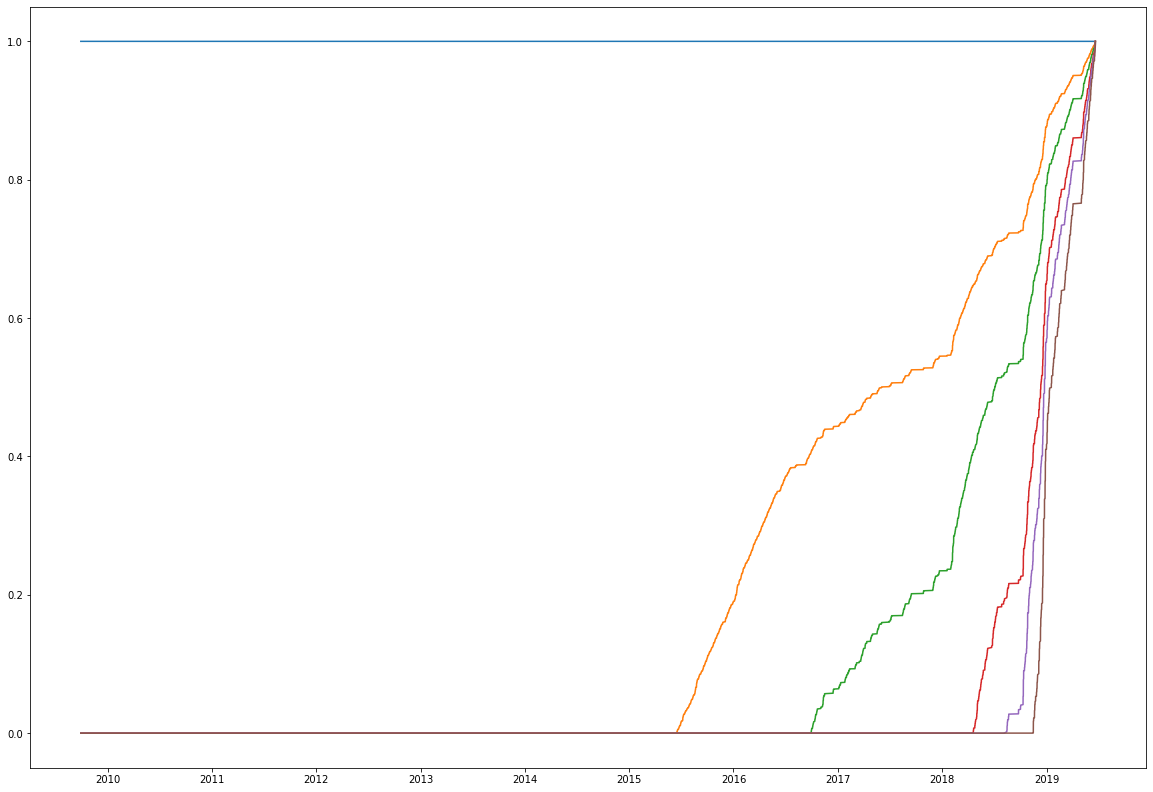

In [144]:
for i in [1, .75, .5, 0, -.25, -.5]:
    clfW = getExpTimeDecay(out['tW'], i, .75)
    plt.plot(clfW)

### 4.5
Consider we apply meta-labels to events determined by a trend-following model. Suppose that two thirds of the labels are 0 and one third of the labels are 1.  

If we fit a classifier without balancing the class weights, then the model will maximize the accuracy of the most common labels, and not give enough weight to the '1' labels.  

A label 1 means a true positive, and a label 0 means a false positive. By applying balanced class weights, we are forcing the classifier to pay more attention to the true positives, and less attention to the false positives.  
This makes sense since there is no reason to favor the accuracy of one class over the other. If we did not balance class weights, then there would be an over-emphasis on the 0 label for no good reason.  

The distribution of the predicted labels before applying balanced class weights would by 2/3 0 and 1/3 1. After balancing, the distribution of the two classes will be equal.

### 4.6
Updating draw probabilites for the final draw in section 4.5.3, pg. 65

In [145]:
t1 = pd.Series([2,3,5], index=[0,2,4]) # index = time of feature observed, value is time of label determined
barIx = range(t1.max() + 1) # index of all bars
indM = fml.getIndMatrix(barIx,t1)
indM  # binary matrix indicating which price bar influences the label for each observation

,0,1,2
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,0.0,1.0
5,0.0,0.0,1.0


In [153]:
# randomly select a number from our features (1, 2, 3)
phi = [1]  # example: we select feature2

avgU = pd.Series()
for i in indM:
    indM_ = indM[phi+[i]] # reduce indM
    avgU.loc[i] = fml.getAvgUniqueness(indM_).iloc[-1]

print('Average Uniqueness:')
print(avgU)

Average Uniqueness:
0    0.833333
1    0.500000
2    1.000000
dtype: float64


In [155]:
# Updated probabilities for 2nd draw
# Shown in book as = {5/14, 3/14, 6/14}
# Feature3 has highest probability since no overlap with feature we just selected (feature2)
prob1 = avgU / avgU.sum()
print('Feature draw probabilities:')
print(prob1)

Feature draw probabilities:
0    0.357143
1    0.214286
2    0.428571
dtype: float64


In [156]:
# In 2nd draw, we select feature3 i.e. phi[2]
phi = [1,2] 

avgU = pd.Series()
for i in indM:
    indM_ = indM[phi+[i]] # reduce indM
    avgU.loc[i] = fml.getAvgUniqueness(indM_).iloc[-1]

print('Average Uniqueness:')
print(avgU)

Average Uniqueness:
0    0.833333
1    0.500000
2    0.500000
dtype: float64


In [157]:
# Feature1 has greatest probability since it hasn't been selected yet i.e. less overlap
# prob for 3rd draw = {5/11, 3/11, 3/11}
prob2 = avgU / avgU.sum()
print('Feature draw probabilities:')
print(prob2)

Feature draw probabilities:
0    0.454545
1    0.272727
2    0.272727
dtype: float64


### 4.7
Suppose that feature 2 is picked again in the second draw (instead of feature 3 as above). Updated probabilities would be as follows:

In [159]:
t1 = pd.Series([2,3,5],index=[0,2,4]) # index = time of feature observed, value is time of label determined
barIx = range(t1.max() + 1) # index of all bars
indM = fml.getIndMatrix(barIx, t1)

phi = [1]  # example: we select feature2
avgU = pd.Series()
for i in indM:
    indM_ = indM[phi+[i]] # reduce indM
    avgU.loc[i] = fml.getAvgUniqueness(indM_).iloc[-1]

# Updated probabilities for 2nd draw
# Feature3 has highest probability since no overlap with feature we just selected (feature2)
prob1 = avgU / avgU.sum()
print('Feature draw probabilities:')
print(prob1)

# In 2nd draw, we select feature2 again
phi = [1, 1]
avgU = pd.Series()
for i in indM:
    indM_ = indM[phi+[i]] # reduce indM
    avgU.loc[i] = fml.getAvgUniqueness(indM_).iloc[-1]

# Feature3 again has even greater probability than before since still no overlap
# prob for 3rd draw = {7/19, 3/19, 9/19}
prob2 = avgU/avgU.sum()
print('\nFeature draw probabilities:')
print(prob2)

Feature draw probabilities:
0    0.357143
1    0.214286
2    0.428571
dtype: float64

Feature draw probabilities:
0    0.368421
1    0.157895
2    0.473684
dtype: float64
